In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import nibabel as nb
from skimage.measure import block_reduce
import CMR_HFpEF_Analysis.functions_collection as ff
import CMR_HFpEF_Analysis.Image_utils as util
import Bspline

2023-02-07 17:34:44.392370: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


load a case:

(128, 128, 60) (1.25, 1.25, 1.9999999)


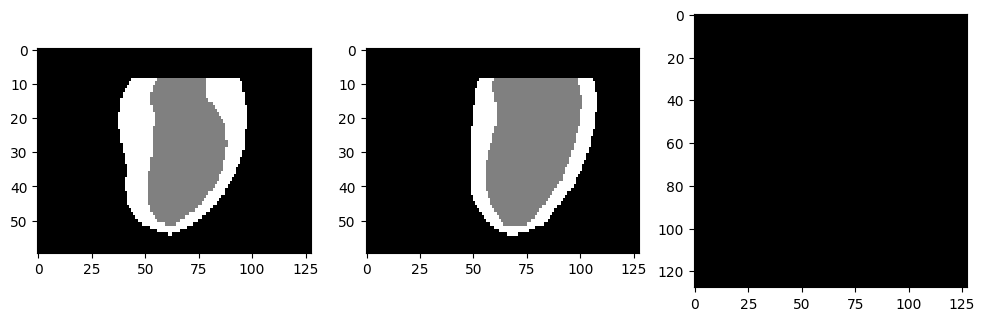

In [2]:
# filename = '/mnt/mount_zc_NAS/HFpEF/data/simulated_data_version2//ES/ds/data_flip_clean.nii.gz'
filename = '/mnt/mount_zc_NAS/HFpEF/data/simulated_data_version2/1256/ED/ds/HR/HR_data_flip_clean.nii.gz'
# filename = '/mnt/mount_zc_NAS/HFpEF/predict/Combined/Iteration_C/round_1/images/1256/ED/normal_motion_10/pred_img_HR_final_flip_clean.nii.gz'
img_file = nb.load(filename)
header = img_file.header
spacing = img_file.header.get_zooms()
affine = img_file.affine
img = img_file.get_fdata()
img= np.round(img)
img = img.astype(int)
img = util.relabel(img,4,0)
print(img.shape,spacing)

plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(img[64, ...].T, 'gray', aspect=spacing[2] / spacing[1])
plt.subplot(132); plt.imshow(img[:,64, :].T, 'gray', aspect=spacing[2] / spacing[0])
plt.subplot(133); plt.imshow(img[:,:,2], 'gray', aspect=spacing[0] / spacing[1])

# Find center-line points, plot them in a B-spline and Find the corresponding control points

In [9]:
# remove incomplete basal:
lv_mass = []
heart_mass = []
for i in range(0,img.shape[-1]):
    I = img[:,:,i]
    # lv mass
    I_LV = np.copy(I)
    I_LV[I_LV != 1] = 0
    lv_mass.append(np.sum(I_LV))
    # heart mass
    heart_mass.append(np.sum(I))
print(lv_mass)
print(heart_mass)


[0, 0, 0, 0, 0, 41, 135, 204, 262, 327, 407, 481, 549, 605, 665, 730, 797, 854, 908, 960, 1014, 1058, 1101, 1141, 1187, 1234, 1273, 1299, 1311, 1321, 1339, 1363, 1380, 1394, 1414, 1430, 1452, 1462, 1475, 1476, 1480, 1482, 1485, 1492, 1474, 1458, 1426, 1392, 1348, 1304, 1239, 1114, 588, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 224, 504, 847, 1027, 1190, 1342, 1533, 1685, 1847, 2011, 2177, 2339, 2472, 2605, 2734, 2856, 2968, 3076, 3204, 3315, 3417, 3529, 3642, 3731, 3791, 3877, 3961, 4099, 4183, 4244, 4318, 4384, 4430, 4460, 4480, 4483, 4540, 4552, 4544, 4543, 4518, 4492, 4464, 4410, 4304, 4208, 4084, 3925, 3576, 1690, 170, 0, 0, 0, 0, 0, 0]


[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51] 43
[(nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), array([78.38, 68.19]), array([78.47, 67.92]), array([78.55, 67.78]), array([78.52, 67.71]), array([78.45, 67.52]), array([78.35, 67.42]), array([78.18, 67.44]), array([78.06, 67.5 ]), array([77.9 , 67.56]), array([77.71, 67.63]), array([77.48, 67.72]), array([77.24, 67.78]), array([77.07, 67.83]), array([76.85, 67.87]), array([76.59, 67.94]), array([76.26, 68.14]), array([76.02, 68.2 ]), array([75.77, 68.23]), array([75.51, 68.21]), array([75.26, 68.36]), array([74.93, 68.37]), array([74.72, 68.37]), array([74.42, 68.34]), array([74.14, 68.27]), array([73.88, 68.08]), array([73.65, 68.01]), array([73.46, 67.78]), array([73.15, 67.56]), array([72.97, 67.15]), array([72.73, 66.77]), array([72.47, 66.38]), arr

/usr/local/lib/python3.8/dist-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


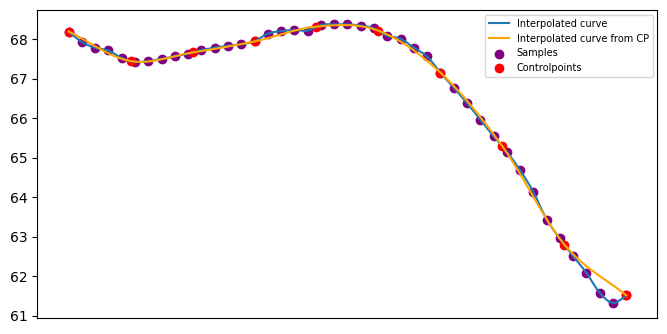

In [11]:
# find centerline points
# only take LV center points
slice_list = []; center_list_raw = []
for i in range(0,img.shape[-1]):
    I = img[:,:,i]
    # no LV:
    if np.where(I == 1)[0].shape[0] < 50 :
        center_list_raw.append(util.center_of_mass(np.zeros((20,20)),0,large = True))
        continue
    slice_list.append(i)
    center_list_raw.append(np.round(util.center_of_mass(I,0,large = True),2))
print(slice_list,  len(slice_list))
print(center_list_raw)    # with nan
center_list = ff.remove_nan(center_list_raw)
print(center_list)  # without nan

# fit B-spline
N = 10

# original spline S by centerline points
x = np.linspace(0,1,len(center_list))
y = np.asarray([center_list[i][1] for i in range(0,len(center_list))])
xs = np.linspace(x[0],x[-1],100)
ys = Bspline.bspline(x, y, xs)

# find N Control points to represent this spline S
xc = np.linspace(x[0], x[-1],N)
yc = Bspline.bspline(x,y,xc)
# print(yc)

# use N control points to build another spline, S'
xcs = np.linspace(x[0],x[-1],100)
ycs = Bspline.bspline(xc, yc, xcs)

# in S', find the center points
yy = Bspline.bspline(xc, yc,x)
# print(abs(yy - y), np.mean(abs(yy-y)))

# use our function
yc_f, _ = Bspline.bspline_and_control_points(center_list, N, x_or_y = 'y')

plt.figure(figsize = (8,4))
plt.scatter(x, y, label='Samples', color='purple')
plt.plot(xs, ys, label='Interpolated curve')
plt.scatter(xc, yc, label='Controlpoints', color='red')
plt.plot(xcs, ycs, label='Interpolated curve from CP', color = 'orange')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
plt.legend(fontsize = 7)
plt.show()

[66.21       67.64666667 70.35407407 71.77       73.44148148 75.08814815
 79.49      ]
[ 0.    1.44  4.14  5.56  7.23  8.88 13.28]
[0.         0.0225     0.0646875  0.086875   0.11296875 0.13875
 0.2075    ]


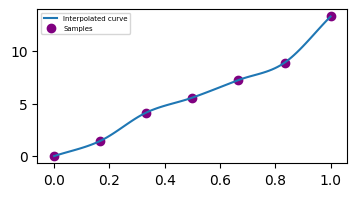

In [6]:
# calculate the delta, set the first control points as 0
delta, delta_n = Bspline.delta_for_centerline(np.round(yc_f,2), image_shape = 128)
print(yc_f)
print(delta)
print(delta_n)

# original spline S by centerline points
x = np.linspace(0,1,delta.shape[0])
xs = np.linspace(x[0],x[-1],100)
ys = Bspline.bspline(x, delta, xs)


plt.figure(figsize = (4,2))
plt.scatter(x, delta, label='Samples', color='purple')
plt.plot(xs, ys, label='Interpolated curve')
plt.legend(fontsize = 5)
plt.show()

In [107]:
print(np.diff(delta[1:]))
np.std(np.diff(delta[1:]))/np.mean(abs(np.diff(delta[1:])))

[-1.99 -0.93  0.24  0.18  3.04]
1.296065355374932


# Try to downsample the image to see how centerline points change

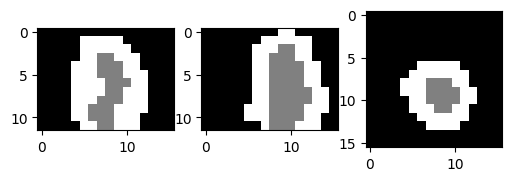

In [5]:
pool = block_reduce(img,block_size = (8,8,1), func = np.max)
plt.figure(figsize = (6,2))
plt.subplot(131); plt.imshow(pool[8, ...].T, 'gray', aspect=spacing[2] / spacing[1] / 8)
plt.subplot(132); plt.imshow(pool[:,8, :].T, 'gray', aspect=spacing[2] / spacing[0] / 8)
plt.subplot(133); plt.imshow(pool[:,:,4], 'gray', aspect=spacing[0] / spacing[1])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 11
[array([9.33, 7.12]), array([9.03, 7.64]), array([9.05, 7.93]), array([9.35, 8.09]), array([9.48, 8.16]), array([9.46, 8.15]), array([9.54, 8.12]), array([9.69, 8.  ]), array([9.53, 7.96]), array([9.17, 7.88]), array([9.54, 8.29])]


/usr/local/lib/python3.8/dist-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


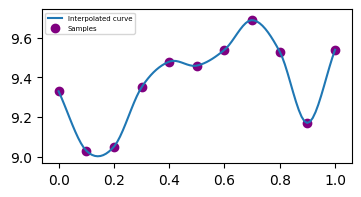

In [6]:
# find centerline points
# only take LV center points
slice_list = []; center_list_raw = []
for i in range(0,pool.shape[-1]):
    I = pool[:,:,i]
    # no LV:
    if np.where(I == 1)[0].shape[0] == 0 :
        center_list_raw.append(util.center_of_mass(np.zeros((20,20)),0,large = True))
        continue
    slice_list.append(i)
    center_list_raw.append(np.round(util.center_of_mass(I,0,large = True),2))
print(slice_list,  len(slice_list))
center_list = ff.remove_nan(center_list_raw)
print(center_list)  # without nan

# fit B-spline
N = 8

# original spline S by centerline points
x = np.linspace(0,1,len(center_list))
y = np.asarray([center_list[i][0] for i in range(0,len(center_list))])
xs = np.linspace(x[0],x[-1],100)
ys = Bspline.bspline(x, y, xs)


plt.figure(figsize = (4,2))
plt.scatter(x, y, label='Samples', color='purple')
plt.plot(xs, ys, label='Interpolated curve')
plt.legend(fontsize = 5)
plt.show()

# Test slice augmentation and corresponding centerline change

In [8]:
img_lv = util.remove_non_LV_slices(img)
for i in range(0,img_lv.shape[-1]):
    if np.where(img[:,:,i] == 1)[0].shape[0] == 0:
        assert np.sum(img[:,:,i]) == 0

img_low_aug, lv_slice, aug_slice_num, lv_slice_augment = util.make_slice_augmentation(img, np.array([0]), remove_slice_num=1, do_high_resolution= False, factor = 5, fill_apex= False)
print(lv_slice, aug_slice_num, lv_slice_augment)

# load centerline points saved
centerline_file = os.path.join(os.path.dirname(os.path.dirname(filename)), 'center_list.npy')
center_list = np.load(centerline_file, allow_pickle = True)
center_list_aug = ff.remove_nan(center_list[lv_slice_augment])
# print(center_list, center_list_aug)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 10 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


[61.9        65.13778426 67.79244898 69.02174927 68.47772595 67.50661808
 66.24956268 65.64      ]


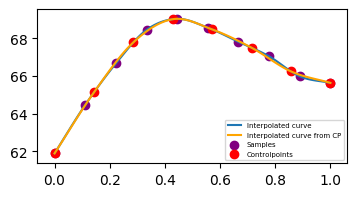

In [12]:
# use our function to find center points
yc ,_ = Bspline.bspline_and_control_points(center_list_aug, 8, x_or_y = 'y')

N = 8
# original spline S
x = np.linspace(0,1,len(center_list_aug))
y = np.asarray([center_list_aug[i][1]  for i in range(0,len(center_list_aug))])
xs = np.linspace(x[0],x[-1],100)
ys = Bspline.bspline(x, y, xs)

# find N Control points to represent this spline S
xc = np.linspace(x[0], x[-1],N)

# use N control points to build another spline, S'
xcs = np.linspace(x[0],x[-1],100)
ycs = Bspline.bspline(xc, yc, xcs)

# in S', find the center points
yy = Bspline.bspline(xc, yc,x)

print(yc)
plt.figure(figsize = (4,2))
plt.scatter(x, y, label='Samples', color='purple')
plt.plot(xs, ys, label='Interpolated curve')
plt.scatter(xc, yc, label='Controlpoints', color='red')
plt.plot(xcs, ycs, label='Interpolated curve from CP', color = 'orange')
plt.legend(fontsize = 5)
plt.show()

[61.9        65.13778426 67.79244898 69.02174927 68.47772595 67.50661808
 66.24956268 65.64      ]
[0.         3.23778426 5.89244898 7.12174927 6.57772595 5.60661808
 4.34956268 3.74      ]
[0.05059038 0.09206952 0.11127733 0.10277697 0.08760341 0.06796192
 0.0584375 ]


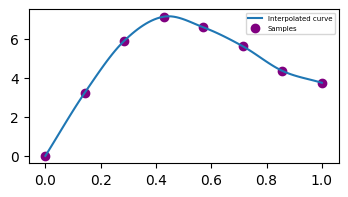

In [13]:
# do delta
delta, delta_n = Bspline.delta_for_centerline(yc, image_shape = 128)
print(yc)
print(delta)
print(delta_n[1:8])

# original spline S by centerline points
x = np.linspace(0,1,delta.shape[0])
xs = np.linspace(x[0],x[-1],100)
ys = Bspline.bspline(x, delta, xs)


plt.figure(figsize = (4,2))
plt.scatter(x, delta, label='Samples', color='purple')
plt.plot(xs, ys, label='Interpolated curve')
plt.legend(fontsize = 5)
plt.show()